# Example of using pandasql library for data analysis

In [20]:
%matplotlib inline
import pandas as pd
import pandasql as ps
from datetime import datetime
import seaborn
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

In [2]:
pd.__version__

u'0.18.0'

In [3]:
project_submissions = pd.read_csv('./data/project_submissions.csv')
daily_engagements = pd.read_csv('./data/daily_engagement.csv')
enrollments = pd.read_csv('./data/enrollments.csv')

## Simple SQL query 
getting accounts and date with maximum total time spent on Udacity

In [21]:
# pandasql code
def example1_pandasql(daily_engagements):
    simple_query = '''
        SELECT 
            acct, 
            total_minutes_visited,
            utc_date
        FROM daily_engagements 
        ORDER BY total_minutes_visited desc
        LIMIT 10
        '''
    return ps.sqldf(simple_query, locals())

# pandas code
def example1_pandas(daily_engagements):
    return daily_engagements[['acct', 'total_minutes_visited', 'utc_date']].sort_values(by ='total_minutes_visited', ascending = False)[:10]

In [22]:
example1_pandasql(daily_engagements)

,acct,total_minutes_visited,utc_date
0,317.0,1030.883197,2015-07-11
1,328.0,945.538914,2015-07-09
2,198.0,876.512846,2014-12-30
3,163.0,872.633923,2015-07-10
4,573.0,866.405226,2015-07-11
5,303.0,856.634726,2015-05-14
6,619.0,853.253236,2015-07-10
7,163.0,850.519340,2015-07-09
8,108.0,820.879483,2015-02-20
9,278.0,816.895443,2015-07-09


In [23]:
example1_pandas(daily_engagements)

,acct,total_minutes_visited,utc_date
54536,317.0,1030.883197,2015-07-11
56403,328.0,945.538914,2015-07-09
33728,198.0,876.512846,2014-12-30
27699,163.0,872.633923,2015-07-10
97492,573.0,866.405226,2015-07-11
51779,303.0,856.634726,2015-05-14
105968,619.0,853.253236,2015-07-10
27698,163.0,850.519340,2015-07-09
18394,108.0,820.879483,2015-02-20
47372,278.0,816.895443,2015-07-09


## SQL query with aggregating functions
Let's see whether there's weekly seasonality: on average students spent more time on weekends then on weekdays

In [7]:
daily_engagements['weekday'] = map(lambda x: datetime.strptime(x, '%Y-%m-%d').strftime('%A'), daily_engagements.utc_date)

In [8]:
daily_engagements.head()

,acct,utc_date,num_courses_visited,total_minutes_visited,lessons_completed,projects_completed,weekday
0,0.0,2015-01-09,1.0,11.679374,0.0,0.0,Friday
1,0.0,2015-01-10,2.0,37.284887,0.0,0.0,Saturday
2,0.0,2015-01-11,2.0,53.633746,0.0,0.0,Sunday
3,0.0,2015-01-12,1.0,33.489270,0.0,0.0,Monday
4,0.0,2015-01-13,1.0,64.779678,0.0,0.0,Tuesday


In [9]:
# pandasql code
def example2_pandasql(daily_engagements):
    aggr_query = '''
        SELECT 
            avg(total_minutes_visited) as total_minutes_visited,
            weekday
        FROM daily_engagements 
        GROUP BY weekday
        '''
    return ps.sqldf(aggr_query, locals()).set_index('weekday')

# pandas code
def example2_pandas(daily_engagements):
    return pd.DataFrame(daily_engagements.groupby('weekday').total_minutes_visited.mean())

In [10]:
weekday_engagement = example2_pandasql(daily_engagements)
weekday_engagement

,total_minutes_visited
weekday,
Friday,23.156233
Monday,26.418982
Saturday,21.725677
Sunday,23.539406
Thursday,24.685176
Tuesday,26.857676
Wednesday,25.362789


In [11]:
example2_pandas(daily_engagements)

,total_minutes_visited
weekday,
Friday,23.156233
Monday,26.418982
Saturday,21.725677
Sunday,23.539406
Thursday,24.685176
Tuesday,26.857676
Wednesday,25.362789


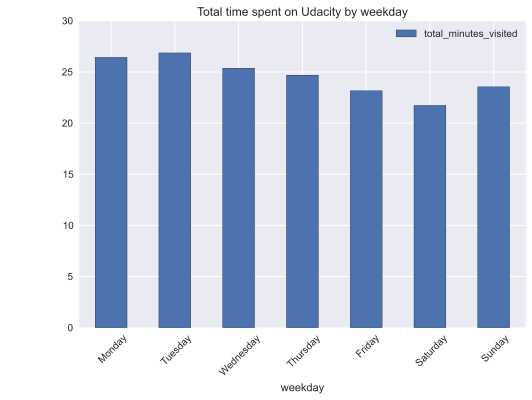

In [12]:
week_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_engagement.loc[week_order].plot(kind = 'bar', rot = 45, title = 'Total time spent on Udacity by weekday')

# Joining tables
Let's see whether students that canceled program was spending less time on Udacity within first week of enrollment.
Note we need to filter out Udacity test users not to spoil statistics. Also we need to take into account the fact that student may join several times.

In [13]:
# pandasql code
def example3_pandasql(enrollments, daily_engagements):
    join_query = '''
        SELECT 
            avg(avg_acct_total_minutes) as avg_total_minutes, 
            status
        FROM
            (SELECT 
                avg(total_minutes_visited) as avg_acct_total_minutes, 
                status, 
                account_key
            FROM
                (SELECT 
                    e.account_key, 
                    e.status,
                    de.total_minutes_visited,
                    (cast(strftime('%s',de.utc_date) as interger) - cast(strftime('%s',e.join_date) as interger))/(24*60*60) as days_since_joining,
                    (cast(strftime('%s',e.cancel_date) as interger) - cast(strftime('%s', de.utc_date) as interger))/(24*60*60) as days_before_cancel
                FROM enrollments as e JOIN daily_engagements as de ON (e.account_key = de.acct)
                WHERE (is_udacity = 0) AND (days_since_joining < 7) AND (days_since_joining >= 0)
                    AND ((days_before_cancel >= 0) OR (status = 'current'))
                )
            GROUP BY status, account_key)
        GROUP BY status
    '''
    return ps.sqldf(join_query, locals()).set_index('status')

# pandas code
def example3_pandas(enrollments, daily_engagements):
    join_df = pd.merge(daily_engagements, 
                   enrollments[enrollments.is_udacity == 0], 
                   how = 'inner', 
                   right_on ='account_key', 
                   left_on = 'acct')
    join_df = join_df[['account_key', 'status', 'total_minutes_visited', 'utc_date', 'join_date', 'cancel_date']]

    join_df['days_since_joining'] = map(lambda x: x.days, 
                                        pd.to_datetime(join_df.utc_date) - pd.to_datetime(join_df.join_date))

    join_df['before_cancel'] = (pd.to_datetime(join_df.utc_date) <= pd.to_datetime(join_df.cancel_date))
    join_df = join_df[join_df.before_cancel | (join_df.status == 'current')]

    join_df = join_df[(join_df.days_since_joining < 7) & (join_df.days_since_joining >= 0)]
    avg_account_total_minutes = pd.DataFrame(join_df.groupby(['account_key', 'status'], as_index = False)
                                                     .total_minutes_visited.mean())
    avg_total_minutes= pd.DataFrame(avg_account_total_minutes.groupby('status').total_minutes_visited.mean())
    avg_total_minutes.columns = ['avg_total_minutes']
    return avg_total_minutes

In [14]:
example3_pandasql(enrollments, daily_engagements)

,avg_total_minutes
status,
canceled,30.884667
current,47.307307


In [15]:
example3_pandas(enrollments, daily_engagements)

,avg_total_minutes
status,
canceled,30.884667
current,47.307307


# Estimating time elapsed

In [16]:
import time

def count_mean_time(func, params, N =5):
    total_time = 0
    for i in range(N):
        time1 = time.time()
        if len(params) == 1:
            tmp_df = func(params[0])
        elif len(params) == 2:
            tmp_df = func(params[0], params[1])
        time2 = time.time()
        total_time += (time2 - time1)
    return total_time/N

## Example #1

In [32]:
ex1_times = []
for count in range(1000, 137000, 1000):
    pandasql_time = count_mean_time(example1_pandasql, [daily_engagements[:count]])
    pandas_time = count_mean_time(example1_pandas, [daily_engagements[:count]])
    ex1_times.append({'count': count, 'pandasql_time': pandasql_time, 'pandas_time': pandas_time})

In [33]:
ex1_times_df = pd.DataFrame(ex1_times).set_index('count')

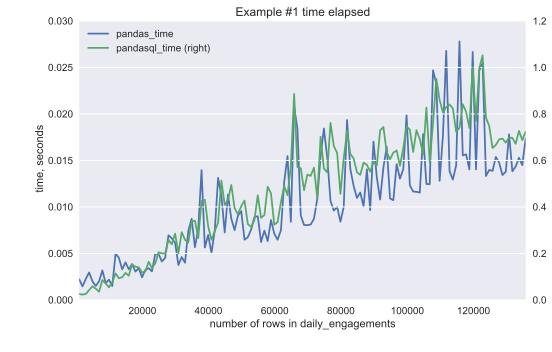

In [34]:
ax = ex1_times_df.plot(secondary_y = 'pandasql_time', title = 'Example #1 time elapsed')
ax.set_xlabel('number of rows in daily_engagements')
ax.set_ylabel('time, seconds')

## Example #2

In [35]:
ex2_times = []
for count in range(1000, 137000, 1000):
    pandasql_time = count_mean_time(example2_pandasql, [daily_engagements[:count]])
    pandas_time = count_mean_time(example2_pandas, [daily_engagements[:count]])
    ex2_times.append({'count': count, 'pandasql_time': pandasql_time, 'pandas_time': pandas_time})

In [40]:
ex2_times_df = pd.DataFrame(ex2_times).set_index('count')

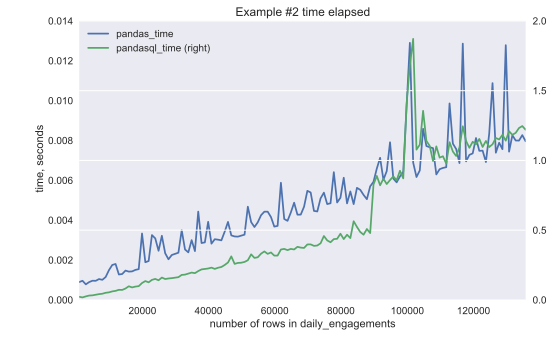

In [41]:
ax = ex2_times_df.plot(secondary_y = 'pandasql_time', title = 'Example #2 time elapsed')
ax.set_xlabel('number of rows in daily_engagements')
ax.set_ylabel('time, seconds')

## Example #3

In [47]:
all_users = enrollments.account_key.unique().tolist()
len(all_users)

1302

In [55]:
ex3_times = []
for users_count in range(10, 1310, 10):
    users = all_users[:users_count]
    enrollments_sample = enrollments[enrollments.account_key.isin(users)]
    daily_engagements_sample = daily_engagements[daily_engagements.acct.isin(users)]
    count = daily_engagements_sample.shape[0]
    pandasql_time = count_mean_time(example3_pandasql, [enrollments_sample, daily_engagements_sample])
    pandas_time = count_mean_time(example3_pandas, [enrollments_sample, daily_engagements_sample])
    ex3_times.append({'count': count, 'pandasql_time': pandasql_time, 'pandas_time': pandas_time})

In [56]:
ex3_times_df = pd.DataFrame(ex3_times).set_index('count')

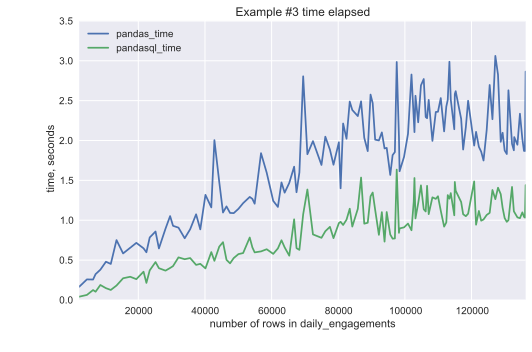

In [59]:
ax = ex3_times_df.plot(title = 'Example #3 time elapsed')
ax.set_xlabel('number of rows in daily_engagements')
ax.set_ylabel('time, seconds')